In [10]:
! pip install azure-ai-documentintelligence==1.0.0b2

In [11]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeResult
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest

import os
import cv2
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import date, datetime

In [12]:
def read_image(path: str, show_img : bool = False) -> bytes:
    """Read image data and convert it to bytes

    Args:
        path (str): the path to the image
        show_img (bool, optional): show image. Defaults to False.

    Returns:
        bytes: bytes representation of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if show_img:
        plt.imshow(image)

    _, buffer = cv2.imencode('.jpg', image)
    jpeg_bytes = buffer.tobytes()

    return jpeg_bytes

In [13]:
@dataclass
class Person:
    """Simple person entity
    """
    first_name: str
    last_name: str
    personal_number: str
    date_of_birth: date

In [14]:
def read_document_data(image : bytes) -> AnalyzeResult:
    """Read and analyze document data with Azure Document Intelligence

    Args:
        image (bytes): image data

    Returns:
        AnalyzeResult: analysis result
    """
    # read credentials & endpoint for OCR
    subscription_key = os.environ["VISION_KEY"]
    endpoint = os.environ["VISION_ENDPOINT"]

    # initialize DI client
    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=endpoint, credential=AzureKeyCredential(subscription_key)
    )

    # perform & get analysis results
    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-idDocument", AnalyzeDocumentRequest(bytes_source=image
    ))

    result: AnalyzeResult = poller.result()

    return result

In [24]:
def parse_document_data(analysis_result: AnalyzeResult) -> Person:
    """Get data from the AnalyzeResult and parse it to Person entity

    Args:
        analysis_result (AnalyzeResult): DI analysis result

    Returns:
        Person: human identification data
    """
    for doc in analysis_result.documents:
        match doc.doc_type:
            case "idDocument.nationalIdentityCard":
                date_of_birth = datetime.strptime(doc.fields['DateOfBirth'].content, '%d.%m.%Y').date()
                personal_number = doc.fields['DocumentNumber'].content
                first_name = doc.fields['FirstName'].content
                last_name = doc.fields['LastName'].content
                return Person(first_name=first_name, last_name=last_name,
                              personal_number=personal_number, date_of_birth=date_of_birth)
            case "idDocument.driverLicense":
                date_of_birth = datetime.strptime(doc.fields['DateOfBirth'].content, '%d.%m.%Y').date()
                personal_number = doc.fields['PersonalNumber'].content
                first_name = doc.fields['FirstName'].content
                last_name = doc.fields['LastName'].content
                return Person(first_name=first_name, last_name=last_name,
                              personal_number=personal_number, date_of_birth=date_of_birth)
            case "idDocument":
                pass

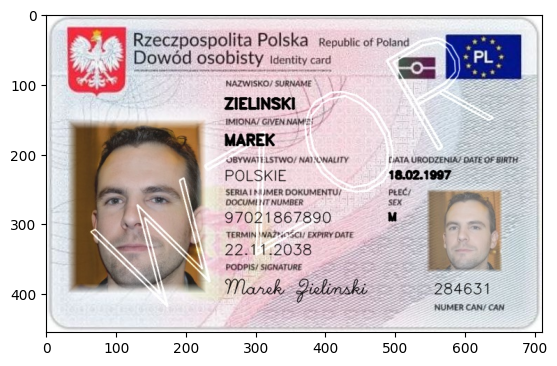

In [16]:
image = read_image('./identity-card/person06.jpg', True)

In [17]:
results = read_document_data(image)

In [25]:
data = parse_document_data(results)
print(data)

Person(first_name='MAREK', last_name='ZIELINSKI', personal_number='97021867890', date_of_birth=datetime.date(1997, 2, 18))
